# Preliminaries

In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation7 import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation7 import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation7 import theta1norm, theta2norm
from dissipationtheory.dissipation7 import gamma_perpendicular, blds_perpendicular
from dissipationtheory.dissipation7 import theta1norm_jit, theta2norm_jit
from dissipationtheory.dissipation7 import gamma_perpendicular_jit, blds_perpendicular_jit
from dissipationtheory.dissipation7 import ExptSweepConductivity

In [3]:
THIS = 'dissipation-theory--Study-43--'
figs = {}

# Set up the cantilever

In [4]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'),
    angle = ureg.Quantity(20, 'degrees'),
    d = ureg.Quantity(38, 'nm'),
    z_c = ureg.Quantity(73, 'nm')
)

In [5]:
cantilever

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 35.000 nm
        cone half angle = 20.000 degree
                 height = 38.000 nm
  tip charge z location = 73.000 nm

# Set up the sample

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  As we vary the conductivity $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.  Pick a starting $\sigma$ and compute the associated charge density that achieves the above target mobility.

In [6]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
sigma = ureg.Quantity(1E-5, 'S/m')
rho = (sigma / (qe * mu)).to('1/m^3')

Set up the sample object.

In [7]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(7300, 'nm'), # 100 times the sample-charge separation
    epsilon_s = ureg.Quantity(complex(20, -0.2), ''),   # change from 20 to 100
    sigma = sigma,
    rho = rho,
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(73, 'nm')
)

Print out the sample parameters, making sure the mobility is correct.

In [8]:
sample1

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 35.000 nm
        cone half angle = 20.000 degree
                 height = 38.000 nm
  tip charge z location = 73.000 nm

semiconductor

             epsilon (real) = 20.000
             epsilon (imag) = -0.200
                  thickness = 7300.0 nm
               conductivity = 1.000e-05 S/m
             charge density = 6.242e+21 m^{-3}
           reference height = 7.300e+01 nm

         roll-off frequency = 1.129e+06 Hz
                   mobility = 1.000e-08 m^2/(V s)
         diffusion constant = 2.585e-10 m^2/s
               Debye length = 1.513e+01 nm
           diffusion length = 2.342e+01 nm
   effective epsilon (real) = 20.000
   effective epsilon (imag) = -2.597

dielectric

  epsilon (real) = 1000000.000
  epsilon (imag) = 0.000
       thickness = infinite

Create the jit sample object.

In [9]:
sample1_jit = SampleModel1Jit(**sample1.args())

# Check friction and BLDS frequency shift

Show that the friction computed in regular Python and compiled Python gives the same result.

In [10]:
gamma_perpendicular(theta1norm,sample1)

<Quantity(0.6770331096580022, 'piconewton * second / meter')>

In [11]:
gamma_perpendicular_jit(theta1norm_jit,sample1_jit)

<Quantity(0.6770331096580012, 'piconewton * second / meter')>

In [12]:
blds_perpendicular(
    theta1norm,
    sample1,
    ureg.Quantity([1e-1, 1e6], 'Hz'),
    ureg.Quantity(1e-3, 'Hz'))

Magnitude,[-17.34882956999054 -17.34882956999054]
Units,hertz


In [13]:
blds_perpendicular_jit(
    theta1norm_jit,
    sample1_jit,
    ureg.Quantity([1e-1, 1e6], 'Hz'),
    1e-3)

Magnitude,[-17.34882956999053 -17.34882956999053]
Units,hertz


# Loop over charge density

I am largely echoing the code from `Study 29` here, but with minor improvements.  Set up an array of modulation frequencies and an array of conductivities.

For code development, set

* `N_omega` = 10
* `N_sigma` = 10

To make paper-quality figures, rerun with

* `N_omega` = 100
* `N_sigma` = 200

In [14]:
N_omega = 100 # 10 or 100
N_sigma = 200 # 20 or 200

In [15]:
omega_m__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=N_omega), 'Hz')

In [16]:
sigma__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-10),
        stop=np.log10(1),
        num=N_sigma), 'S/m')

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  As we vary $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.  Compute a corresponding charge density array.

In [17]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho__array = (sigma__array / (qe * mu)).to('1/m^3')

Get ready to run the simuations.

In [18]:
expt = {}        # many simulations
expt['01'] = {}  # the first simulation

Loop over conductivities, computing the BLDS spectrum and the friction.

In [19]:
%%time

expt['01'] = ExptSweepConductivity('perovskite-like sample')
expt['01'].calculate(theta1norm_jit, sample1_jit, omega_m__array, rho__array, sigma__array)

CPU times: user 27.8 s, sys: 299 ms, total: 28.1 s
Wall time: 29.1 s


# Plot the results

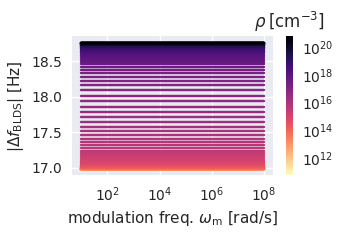

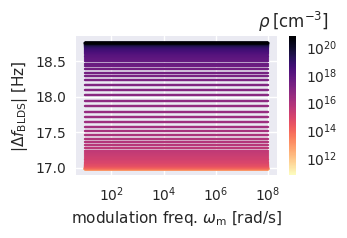

In [20]:
figs['01'] = expt['01'].plot_BLDS(n=2, scaled=False)
figs['01']

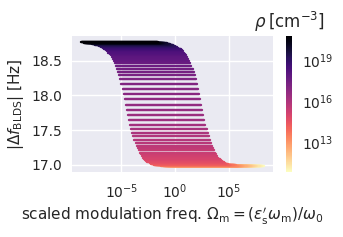

In [21]:
figs['02'] = expt['01'].plot_BLDS(n=2, scaled=True)
figs['02']

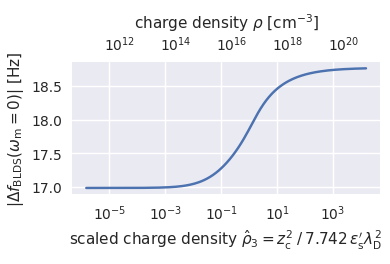

In [22]:
figs['03a'] = expt['01'].plot_BLDS_zero(abs=True)
figs['03a']

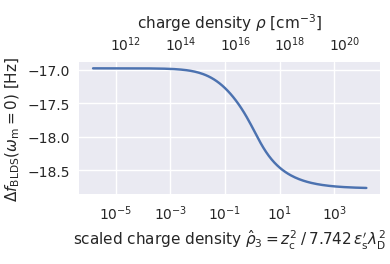

In [23]:
figs['03b'] = expt['01'].plot_BLDS_zero(abs=False)
figs['03b']

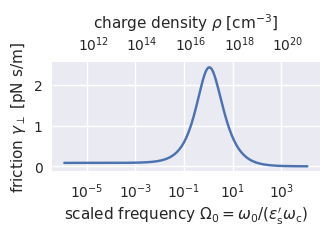

In [24]:
figs['04'] = expt['01'].plot_friction()
figs['04']

::: {.content-hidden when-format="html"}

# Save the figures

In [25]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

:::

::: {.content-hidden when-format="html"}

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-43.ipynb 

Other useful information about this notebook:

- Filename: `dissipation-theory--Study-43.ipynb`
- Continued from: `dissipation-theory--Study-39.ipynb`
- Continued to: ---

:::